In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [0]:
df = pd.read_csv('train_FD001.txt', sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])

In [0]:
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)

In [0]:
#Agregada variable RUL
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
df['RUL'] = RUL_temp
df['RUL'] = df['RUL'].astype(int)
scaler = MinMaxScaler(feature_range=(-1,1))
df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

In [5]:
df.iloc[0:30][:]

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21,RUL
0,1,-1.000000,-0.080460,-0.666667,-1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191
1,1,-0.994460,0.218391,-0.500000,-1.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190
2,1,-0.988920,-0.494253,0.500000,-1.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189
3,1,-0.983380,0.080460,0.000000,-1.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188
4,1,-0.977839,-0.218391,-0.333333,-1.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187
5,1,-0.972299,-0.494253,-0.166667,-1.0,-0.463855,-0.414432,-0.455773,0.552335,-0.636364,-0.749170,-0.630952,0.275053,-0.558824,-0.660336,-0.338977,-0.500000,0.302326,0.305440,186
6,1,-0.966759,0.114943,0.166667,-1.0,-0.234940,-0.072160,-0.476030,0.446055,-0.636364,-0.664363,-0.392857,0.547974,-0.558824,-0.665807,-0.442093,-0.333333,0.488372,0.334438,185
7,1,-0.961219,-0.390805,0.500000,-1.0,-0.186747,-0.480270,-0.367995,0.288245,-0.696970,-0.828861,-0.535714,0.611940,-0.558824,-0.678708,-0.363601,-0.500000,0.286822,0.149959,184
8,1,-0.955679,0.091954,0.166667,-1.0,-0.451807,-0.130586,-0.576300,0.236715,-0.545455,-0.778067,-0.476190,0.321962,-0.500000,-0.734235,-0.631397,-0.333333,0.410853,0.415079,183
9,1,-0.950139,-0.379310,0.166667,-1.0,-0.698795,-0.119250,-0.385213,0.204509,-0.545455,-0.731042,-0.785714,0.321962,-0.470588,-0.696150,-0.202001,-0.166667,0.255814,0.588511,182


In [0]:
features_maps=np.empty((30,14,1))
df_ys = np.zeros((1,1))
for i in range(1,df['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp1 = df[df['n_engine'] == i]
  df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_features = df_temp2.drop(['RUL'],axis = 1)
  df_y = df_temp2['RUL'].to_numpy()
  df_ys = np.append(df_ys,df_y[29:])
  for j in range(len(df_y)-29):
    feature_map = df_features[j:j+30][:]
    features_maps = np.dstack((features_maps, feature_map))
features_maps=np.delete(features_maps, 0, 2)
df_ys = np.delete(df_ys, 0, 0)

In [7]:
#como acceder a un feature map
print(features_maps.shape)
print(feature_map.shape)

(30, 14, 17731)
(30, 14)


In [8]:
print(df_ys.shape)
print(df_y.shape)
features_maps = np.moveaxis(features_maps, 2, 0)
print(features_maps.shape)

(17731,)
(200,)
(17731, 30, 14)


In [9]:
df_ys = np.expand_dims(df_ys,axis=1)
features_maps= np.expand_dims(features_maps,3)
print(df_ys.shape)
print(features_maps.shape)

(17731, 1)
(17731, 30, 14, 1)


In [10]:
from sklearn.utils import shuffle

features_maps, df_ys = shuffle(features_maps, df_ys, random_state=5)

for i in range(len(df_ys)):
  if df_ys[i] >= 125:
    df_ys[i] = 125
  else:
    df_ys[i] = df_ys[i]

print(df_ys)

ys_train = df_ys[:int(len(df_ys)*0.9)]
ys_valid = df_ys[int(len(df_ys)*0.9):]

features_maps_train = features_maps[:int(len(df_ys)*0.9)]
features_maps_valid = features_maps[int(len(df_ys)*0.9):]

[[125.]
 [ 96.]
 [106.]
 ...
 [125.]
 [ 41.]
 [125.]]


# CNN 

Propuesta de Li, Ding, Sun

![Imagen](https://github.com/farayal/memoria_turbofan/blob/master/cnn_regression.png?raw=true)

In [11]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [0]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    #Layer 1
    # Zero-Padding: Para originar un output (20,14) en la siguiente capa
    #X = ZeroPadding2D((5, 0))(X_input)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    #X = ZeroPadding2D((5, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
    #X = ZeroPadding2D((1, 0))(X)
    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(100, activation='tanh', name='fully-connected')(X)
    #X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [13]:
cnnturbofan = cnnturbofan((features_maps.shape[1],features_maps.shape[2],features_maps.shape[3]))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

cnnturbofan.compile(optimizer = "Adam", loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [15]:
history = cnnturbofan.fit(x = features_maps_train, y = ys_train , epochs = 250 ,validation_data=(features_maps_valid,ys_valid))




Train on 15957 samples, validate on 1774 samples
Epoch 1/250





15957/15957 [==============================] - 13s 785us/step - loss: 3943.4021 - root_mean_squared_error: 61.7431 - val_loss: 2129.0241 - val_root_mean_squared_error: 45.9760
Epoch 2/250
15957/15957 [==============================] - 5s 339us/step - loss: 1294.7936 - root_mean_squared_error: 35.4252 - val_loss: 744.2675 - val_root_mean_squared_error: 27.1672
Epoch 3/250
15957/15957 [==============================] - 5s 331us/step - loss: 510.5871 - root_mean_squared_error: 22.3633 - val_loss: 366.1452 - val_root_mean_squared_error: 19.0506
Epoch 4/250
15957/15957 [==============================] - 5s 333us/step - loss: 294.4504 - root_mean_squared_error: 17.0268 - val_loss: 271.3002 - val_root_mean_squared_error: 16.3432
Epoch 5/250
15957/15957 [==============================] - 5s 330us/step - loss: 229.7878 - root_mean_squared_error: 15.0196 - val_loss: 191.3815 - val_root_mean_squared_error: 13.7510
Epoch 6/250
15

In [16]:
  cnnturbofan.summary()

Model: "cnnturbofan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 14, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 30, 14, 10)        110       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 14, 10)        

In [0]:
hola = cnnturbofan.predict(features_maps)

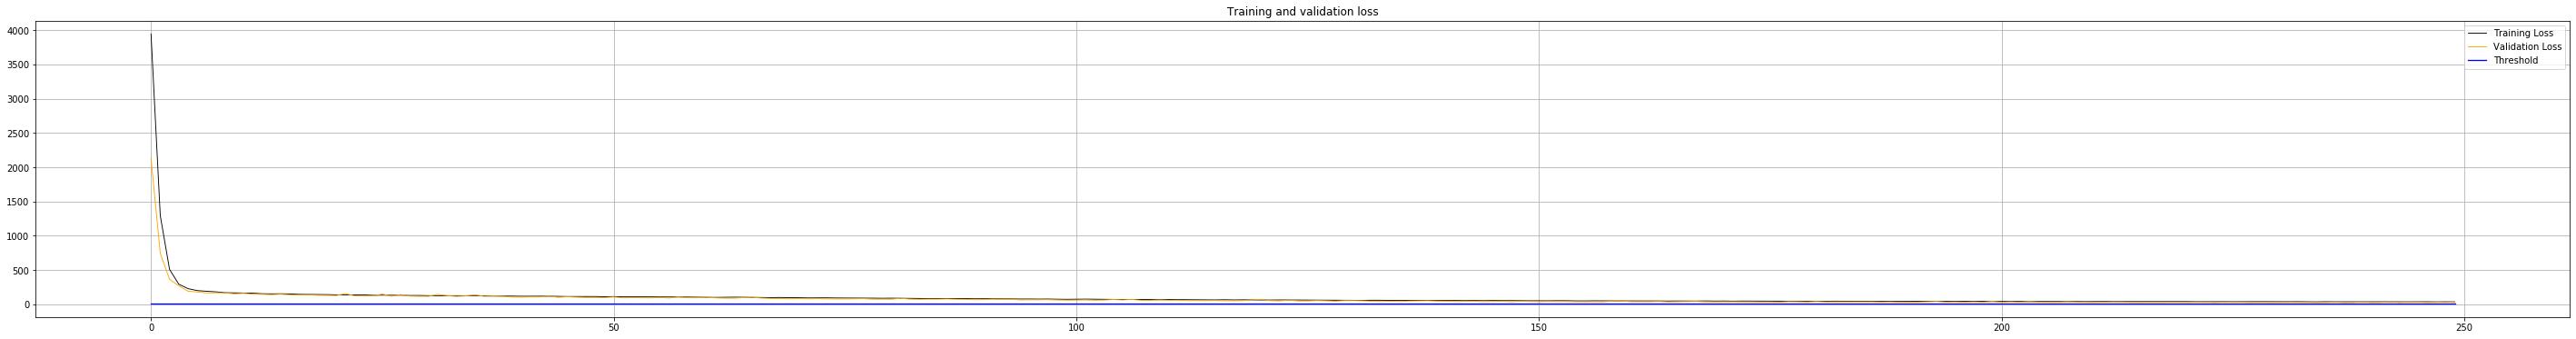

In [18]:
#acc = history.history['mean_absolute_error']
#val_acc = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

##plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(20,6))
plt.grid(True) 
plt.plot(epochs, loss, 'black',lw=0.9, label='Training Loss')
plt.plot(epochs, val_loss, 'orange',lw=0.9, label='Validation Loss')
plt.plot(epochs, np.ones(len(epochs))*12.2, 'blue',lw=1.3,label='Threshold')
plt.title('Training and validation loss')
plt.legend()
  

plt.show()

## Test set

In [0]:
df_t = pd.read_csv('test_FD001.txt', sep = ' ', header = None)
df_t = df_t.drop(columns=[26, 27])
df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])

In [20]:
df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
df_t

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,0.0023,0.0003,100.0,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699


In [21]:
ruls_test= []
rul_file = open("RUL_FD001.txt", "r")
for rul_line in rul_file:
  ruls_test.append(int(rul_line.rstrip(' \n')))
print(ruls_test)


[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [22]:
df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])
df_t

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,-1.000000,0.264368,0.500000,-1.0,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.735680,-0.382070,-0.333333,0.116279,0.323667
1,1,-0.994460,-0.310345,-0.500000,-1.0,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.590463,-0.573682,-0.166667,0.364341,0.373654
2,1,-0.988920,0.034483,0.166667,-1.0,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.688719,-0.082724,-0.166667,0.457364,0.442695
3,1,-0.983380,0.482759,0.000000,-1.0,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.659820,-0.485956,-0.500000,0.333333,0.324220
4,1,-0.977839,0.160920,0.000000,-1.0,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.694499,-0.398230,-0.666667,0.317829,0.432753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,0.069252,0.563218,0.000000,-1.0,0.222892,0.238718,0.132343,0.146538,-0.636364,0.082653,0.000000,-0.147122,-0.647059,0.169780,0.128126,0.000000,-0.209302,-0.162662
13092,100,0.074792,-0.126437,-0.166667,-1.0,0.210843,0.074777,0.343687,0.085346,-0.545455,0.067486,-0.107143,0.006397,-0.382353,0.144700,-0.028088,0.166667,-0.333333,0.057443
13093,100,0.080332,-0.068966,-0.500000,-1.0,0.343373,-0.035971,-0.170493,0.027375,-0.363636,0.122498,-0.142857,0.061834,-0.529412,0.210651,0.015775,0.166667,-0.255814,-0.141397
13094,100,0.085873,-0.436782,0.166667,-1.0,0.234940,0.044256,0.252870,0.133655,-0.484848,0.140806,-0.095238,0.125800,-0.411765,0.244091,0.125048,0.166667,-0.193798,0.037559


In [0]:
features_maps_test=np.empty((30,14,1))
for i in range(1,df_t['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_large = df_temp['sens_8'].count()
  feature_map = df_temp[df_large-30:][:]
  features_maps_test = np.dstack((features_maps_test, feature_map))
features_maps_test=np.delete(features_maps_test, 0, 2)

In [24]:
print(features_maps_test.shape)
print(feature_map.shape)

(30, 14, 100)
(30, 14)


In [25]:
features_maps_test = np.moveaxis(features_maps_test, 2, 0)
print(features_maps_test.shape)

(100, 30, 14)


In [26]:
features_maps_test= np.expand_dims(features_maps_test,3)
print(features_maps_test.shape)

(100, 30, 14, 1)


In [0]:
list1 = np.array(ruls_test)
list2 = np.array(features_maps_test)
idx   = np.argsort(list1)

list1 = np.array(list1)[idx]
list2 = np.array(list2)[idx]

for i in range(len(list1)):
  if list1[i] >= 125:
    list1[i] = 125
  else:
    list1[i] = list1[i]


In [28]:
print(list1)

[  7   8   8   8   9  10  10  11  14  15  16  18  19  20  20  20  21  21
  21  26  28  28  28  28  29  34  37  38  47  48  50  50  50  54  55  57
  58  59  59  63  66  69  72  77  79  82  82  83  84  85  87  89  90  90
  91  91  92  93  94  95  95  96  97  97  97  98 100 103 106 107 107 109
 111 111 112 113 113 114 114 114 115 115 116 117 118 118 119 121 124 125
 125 125 125 125 125 125 125 125 125 125]


In [0]:
holi = cnnturbofan.predict(list2)

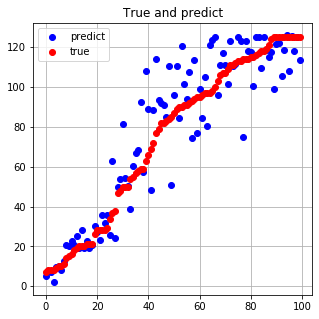

In [30]:
leng = range(100)

#plt.plot(leng, acc, 'r', label='Training accuracy')
#plt.plot(leng, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(5,5))
plt.grid(True) 
plt.plot(leng, holi, 'bo',lw=0.9, label='predict')
plt.plot(leng, list1, 'ro',lw=0.9, label='true')
plt.title('True and predict')
plt.legend()
  

plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(holi, list1))
print(rmse)

14.385772970806748
